#LIME

In [281]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

# Makes sure we see all columns
pd.set_option('display.max_columns', None)

# Load dataset
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

# One-hot encode all categorical columns
categorical_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
encoded = pd.get_dummies(data[categorical_cols], prefix=categorical_cols)

# Update data with new columns
data = pd.concat([encoded, data], axis=1)
data.drop(categorical_cols, axis=1, inplace=True)

# Impute missing values of BMI
data.bmi = data.bmi.fillna(0)

# Drop id as it is not relevant
data.drop(["id"], axis=1, inplace=True)

# Split data into features and target
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

# Split the data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2021)

# Oversample the train data
oversample = RandomOverSampler(sampling_strategy='minority')
x_np, y_np = oversample.fit_resample(X_train.to_numpy(), y_train.to_numpy())

# Convert back to pandas
X_train = pd.DataFrame(x_np, columns=X_train.columns)
y_train = pd.Series(y_np, name=y_train.name)

print(X_train.shape)
print(X_test.shape)
X_train


(7778, 21)
(1022, 21)


,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,53.0,0.0,0.0,175.92,26.9
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,31.0,0.0,0.0,72.60,31.6
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,16.0,0.0,0.0,136.23,22.6
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,17.0,0.0,0.0,83.23,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,38.0,0.0,0.0,162.30,23.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7773,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,76.0,0.0,0.0,57.92,0.0
7774,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,58.0,0.0,0.0,107.26,38.6
7775,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,55.0,1.0,1.0,210.40,40.0
7776,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,45.0,0.0,0.0,224.10,56.6


In [282]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
7773    1
7774    1
7775    1
7776    1
7777    1
Name: stroke, Length: 7778, dtype: int64

In [283]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

F1 Score 0.5332323742217735
Accuracy 0.9442270058708415


In [284]:
import numpy as np

instance_index = 0
instance = X_train.iloc[instance_index]

interpretable_instance = np.where(instance > 0, 1, 0)
print(interpretable_instance)

[0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1]


In [285]:
def proximity_measure_exponential(instance, synthetic_data_point, sigma=1.0):
    # Calculate the Euclidean distance between the instance and synthetic data point
    distance = np.linalg.norm(instance - synthetic_data_point)
    # Apply exponential decay with sigma as the scale parameter
    proximity = np.exp(-distance / (2 * sigma**2))
    return proximity

In [286]:
import numpy as np

perturbed_data_points = []
predicted_values = []

def example_usage(instance_index, X_train, num_samples, model, instance, proximity_measure_function, sigma=1.0):
    instance = X_train.iloc[instance_index]
    random_samples_indices = np.random.choice(len(X_train), num_samples)
    random_samples = X_train.iloc[random_samples_indices]

    # Reshape the random samples
    random_samples_reshaped = random_samples.values.reshape(num_samples, -1)

    # Make predictions for reshaped random samples
    predictions = model.predict(random_samples_reshaped)
    predicted_values.extend(predictions)

    # Calculate proximities for each perturbed sample
    proximities = []
    for i, sample_row in random_samples.iterrows():
        perturbed_data_point = []
        for col in X_train.columns:
            if instance[col] == sample_row[col]:
                perturbed_data_point.append(1)
            else:
                perturbed_data_point.append(0)
        perturbed_data_points.append(perturbed_data_point)

        # Calculate proximity measure between instance and perturbed sample
        proximity = proximity_measure_function(instance, sample_row)
        proximities.append(proximity)


    return perturbed_data_points, proximities


instance_index = 0
instance = X_train.iloc[instance_index]
interpretable_instance = np.where(instance > 0, 1, 0)

perturbed_data_points, proximities = example_usage(instance_index, X_train, 1000, rf, instance, proximity_measure_exponential, sigma=1.0)
print(perturbed_data_points)
print(proximities)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0], [1, 1, 1, 0, 0, 1, 1, 1,

In [287]:
def weighted_linear_regression(X, y, weights):
    X = np.array(X)  # Convert perturbed_data_points to NumPy array
    y = np.array(y)  # Convert predicted_values to NumPy array
    weights = np.array(weights)  # Convert proximities to NumPy array
    print(X)
    print(y)
    print(weights)
    W = np.diag(weights)
    left = (X.T @ W) @ X
    right = (X.T @ W) @ y
    feature_importance = np.linalg.lstsq(left, right, rcond=None)[0]

    return feature_importance

feature_importance = weighted_linear_regression(perturbed_data_points, predicted_values, proximities)
print("Feature importance:", feature_importance)

[[0 0 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]]
[0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1
 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1
 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1
 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0
 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1
 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0
 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 0
 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0
 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 

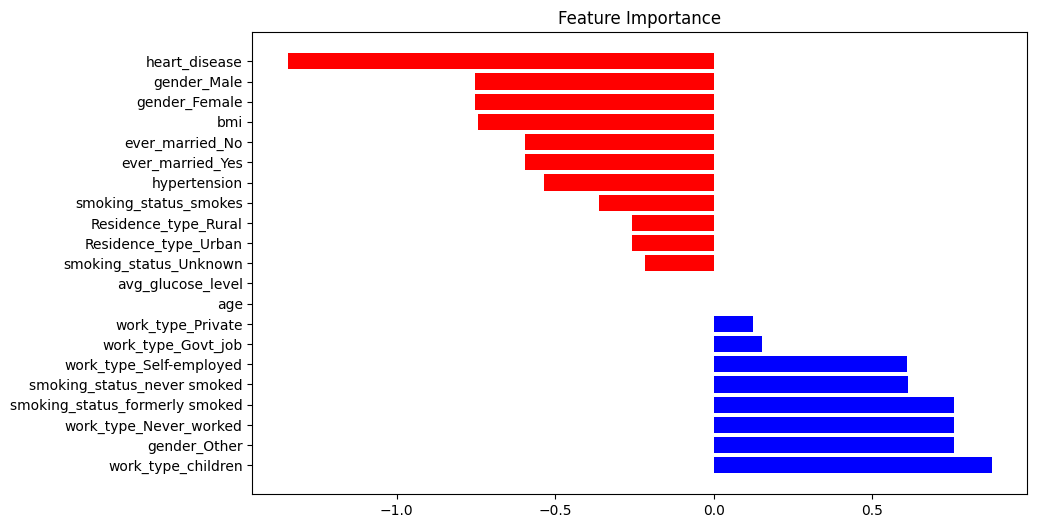

In [288]:
import matplotlib.pyplot as plt


def visualize_feature_importance(feature_importance, feature_names):
    # Normalize feature importance to percentages
    total_importance = np.sum(feature_importance)
    normalized_importance = (feature_importance )

    # Sort the feature importance in descending order
    sorted_indices = np.argsort(normalized_importance)[::-1]
    sorted_importance = normalized_importance[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    # Define colors based on importance sign
    colors = ['red' if imp < 0 else 'blue' for imp in sorted_importance]

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(sorted_importance)), sorted_importance, align='center', color=colors)
    plt.yticks(range(len(sorted_importance)), sorted_feature_names)
    # plt.xlabel('Percentage Importance')
    plt.title('Feature Importance')


    plt.show()

feature_names = ['gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

# Visualize feature importance
visualize_feature_importance(feature_importance, feature_names)


In [289]:
instance_index = 12
instance = X_train.iloc[instance_index]
interpretable_instance = np.where(instance > 0, 1, 0)

perturbed_data_points, proximities = example_usage(instance_index, X_train, 1000, rf, instance, proximity_measure_exponential, sigma=1.0)
print(perturbed_data_points)
print(proximities)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0], [1, 1, 1, 0, 0, 1, 1, 1,

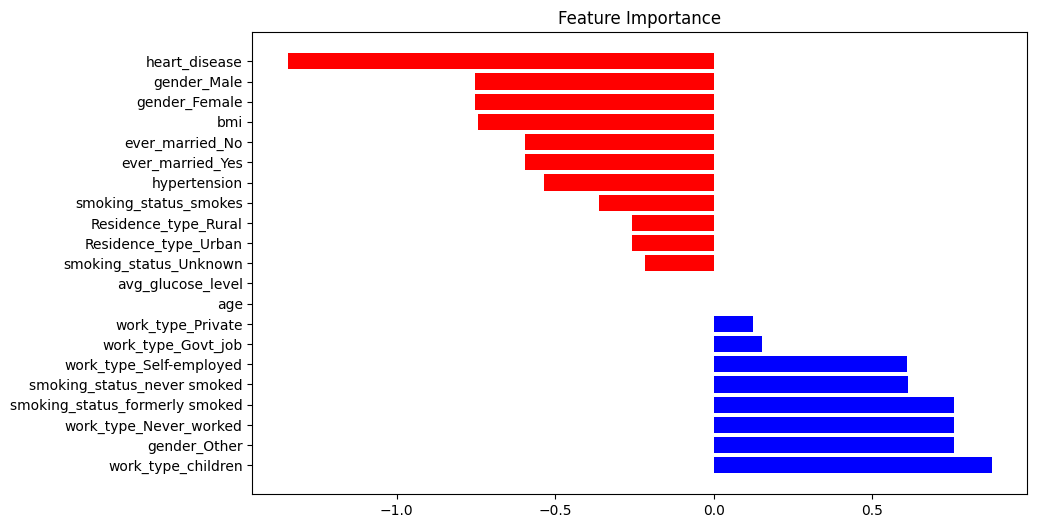

In [290]:
import matplotlib.pyplot as plt


def visualize_feature_importance(feature_importance, feature_names):
    # Normalize feature importance to percentages
    total_importance = np.sum(feature_importance)
    normalized_importance = (feature_importance )

    # Sort the feature importance in descending order
    sorted_indices = np.argsort(normalized_importance)[::-1]
    sorted_importance = normalized_importance[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    # Define colors based on importance sign
    colors = ['red' if imp < 0 else 'blue' for imp in sorted_importance]

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(sorted_importance)), sorted_importance, align='center', color=colors)
    plt.yticks(range(len(sorted_importance)), sorted_feature_names)
    # plt.xlabel('Percentage Importance')
    plt.title('Feature Importance')


    plt.show()

feature_names = ['gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

# Visualize feature importance
visualize_feature_importance(feature_importance, feature_names)


#SHAP

In [296]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


In [297]:
iris = load_iris()
X, y = iris.data, iris.target

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [303]:
!pip install shap

In [313]:
import itertools
import math
import numpy as np

def shapley_regression_values(model, x_train, y_train, n_samples=100):
    n_samples, num_features = x_train.shape[0], x_train.shape[1]
    shapley_values = np.zeros(num_features)

    for i in range(num_features):
        print(f"Computing Shapley regression for feature {i+1}/{num_features}...")
        for subset_size in range(1, num_features + 1):
            for subset in itertools.combinations(range(num_features), subset_size):
                if i not in subset:
                    x_samples = x_train

                    # Create copies of the original data with and without the current subset of features
                    x_with_subset = np.copy(x_samples)
                    x_without_subset = np.copy(x_samples)

                    # Replace values of the selected feature with random numbers in x_without_subset
                    x_without_subset[:, i] = np.random.rand(x_without_subset.shape[0])

                    # Predictions for data with and without the current subset of features
                    predictions_with_subset = model.predict(x_with_subset)
                    predictions_without_subset = model.predict(x_without_subset)

                    # Compute differences in predictions
                    differences = np.mean(predictions_with_subset - predictions_without_subset, axis=0)

                    # Compute weight for this subset
                    weight = math.factorial(subset_size) * math.factorial(num_features - subset_size - 1) / math.factorial(num_features)

                    # Compute Shapley value for feature i and accumulate
                    shapley_values[i] += weight * np.mean(differences)

    return shapley_values

# Example usage
shapley_values_regression = shapley_regression_values(rf_model, X_train, y_train)
print("Shapley regression values:", shapley_values_regression)


Computing Shapley regression for feature 1/4...
Computing Shapley regression for feature 2/4...
Computing Shapley regression for feature 3/4...
Computing Shapley regression for feature 4/4...
Shapley regression values: [-0.00138889  0.00138889  0.03819444 -0.00138889]


In [314]:
import shap
average_prediction = np.mean(rf_model.predict_proba(X), axis=0)
random_sample_idx = 0
explanation = shap.Explanation(values=np.array([shapley_values_regression]),
                                base_values=np.array([average_prediction[random_sample_idx]], dtype='float32'),
                                data=np.array([X_test[random_sample_idx]]),
                                feature_names=iris.feature_names)

# Initialize JavaScript for visualization
shap.initjs()

# Plot the explanation
shap.force_plot(explanation.base_values, explanation.values[0], explanation.data[0], feature_names=explanation.feature_names)

#Grad CAM

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.cm as cm
from torchvision import transforms, datasets
from skimage.transform import resize
import matplotlib.cm as mpl_color_map


In [170]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.avg_pool(x)
        x = x.view(-1, 256 * 14 * 14)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [171]:
class GradCamModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        self.layerhook.append(self.model.conv2.register_forward_hook(self.forward_hook()))

    def activations_hook(self, grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self, x):
        out = self.model(x)
        return out, self.selected_out


In [214]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
custom_model = CustomModel().to(device)
gcmodel = GradCamModel(custom_model).to(device)

index = 0
image, _ = next(iter(train_loader))
inpimg = image.to(device)

out, acts = gcmodel(inpimg)
acts = acts.detach().cpu()
loss = nn.CrossEntropyLoss()(out, torch.tensor([index] * out.size(0)).to(device))
loss.backward()

grads = gcmodel.get_act_grads().detach().cpu()
pooled_grads = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()

for i in range(acts.shape[1]):
    acts[:, i, :, :] *= pooled_grads[i]

Files already downloaded and verified


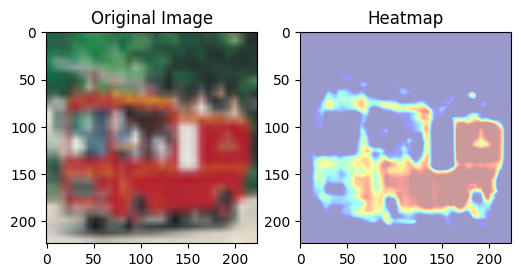

In [215]:
heatmap_j = torch.mean(acts, dim=1).squeeze()
heatmap_j_max = heatmap_j.max(axis=0)[0]
heatmap_j /= heatmap_j_max
heatmap_j = resize(heatmap_j.numpy(), (224, 224), preserve_range=True)
heatmap_j = -1  * heatmap_j
# Define the colormap 'JET'
cmap = plt.get_cmap('jet')

# Apply the colormap to the heatmap
heatmap_j2 = cmap(heatmap_j, alpha=0.4)

# Plot the original image and heatmap
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(((inpimg.cpu().numpy()[0].transpose(1, 2, 0) * np.array([0.2470, 0.2435, 0.2616])) + np.array([0.4914, 0.4822, 0.4465])))
axs[0].set_title('Original Image')
axs[1].imshow(heatmap_j2)
axs[1].set_title('Heatmap')
plt.show()
